In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dpk import model_objs, koopman_probabilistic
sns.set_theme()

In [3]:
# reproducibility
seed = 633

print("[ Using Seed : ", seed, " ]")

import torch
import random
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

[ Using Seed :  633  ]


In [4]:
rank = 200
V = np.load(f"ristretto/2018-19_rank{rank}V.npy")
rank = 30
V = V[:, :rank]

In [5]:
V.mean(axis=0).max()  # should be near 0

0.005654034213349081

In [6]:
scales = V.std(axis=0, keepdims=True)
x = V / scales

In [43]:
periods = np.array([24, 24 * 7, 24 * 365.24], dtype=np.float64)  # hours
l1width = 256
l2width = 512
model = model_objs.SkewNormalNLL(x_dim=rank, num_freqs=3, n=l1width, n2=l2width)

In [8]:
k = koopman_probabilistic.KoopmanProb(model, batch_size=32, device="cpu")
k.init_periods(periods)


In [19]:
total_iters = 0

In [86]:
iters = 1000
total_iters += iters
wd = 1e-3
lrt = 1e-4
k.fit(x, iterations=iters, cutoff=0, weight_decay=wd, lr_theta=lrt, lr_omega=0, verbose=True)

Iteration  0
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598,
          24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598,
          24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.8770874
Iteration  1
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598,
          24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598,
          24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.8770422
Iteration  2
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598,
          24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598,
          24.0000,  168.0000, 8765.7598], grad_fn=<MulBackward0>)
Loss:  0.8769427
Iteration  3
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598

[0.8770874,
 0.8770422,
 0.8769427,
 0.8769446,
 0.87692803,
 0.8768952,
 0.8768825,
 0.87684035,
 0.87683153,
 0.8768595,
 0.87680036,
 0.8767771,
 0.87678355,
 0.8767154,
 0.8767394,
 0.8766958,
 0.8766737,
 0.8766405,
 0.87658787,
 0.8765835,
 0.87664723,
 0.87658125,
 0.8764914,
 0.87654287,
 0.87652975,
 0.8764601,
 0.87647814,
 0.8764295,
 0.87643874,
 0.87638927,
 0.8763872,
 0.87628454,
 0.8763222,
 0.87631947,
 0.87635034,
 0.87629664,
 0.8761997,
 0.8762797,
 0.87617666,
 0.87617385,
 0.8761296,
 0.8761361,
 0.8761531,
 0.87613255,
 0.87610364,
 0.8760189,
 0.8760025,
 0.8759692,
 0.87598,
 0.87597466,
 0.8759558,
 0.8759076,
 0.87583345,
 0.87590057,
 0.8758622,
 0.8758342,
 0.8758418,
 0.87583375,
 0.8757875,
 0.87585616,
 0.87575454,
 0.8756849,
 0.87569946,
 0.8756166,
 0.8756218,
 0.8756253,
 0.8756235,
 0.8756102,
 0.87554175,
 0.8755371,
 0.8755285,
 0.8755138,
 0.8754749,
 0.8754979,
 0.87538385,
 0.8754101,
 0.8754027,
 0.87540567,
 0.87533534,
 0.8753345,
 0.8753335

In [87]:
H = V.shape[0]
params = k.predict(H)
params = model.rescale(loc=0, scale=scales, params=params)
mean_hat = model.mean(params)
std_hat = model.std(params)

In [88]:
param_str = f"SkewNLL_{l1width}_{l2width}_{k.batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
np.save(f"forecasts/params_{param_str}.npy", np.array(params))
torch.save(model.state_dict(), f"forecasts/model_{param_str}.pt")

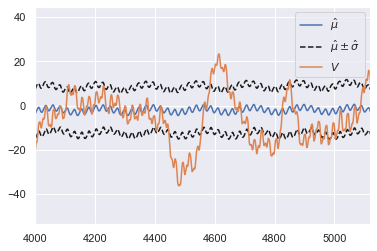

In [73]:
i = 14
plt.plot(mean_hat[:, i], label="$\hat \mu$")
plt.plot(mean_hat[:, i] + std_hat[:, i], "--k", label="$\hat \mu \pm \hat \sigma$")
plt.plot(mean_hat[:, i] - std_hat[:, i], "--k")
plt.plot(V[:H, i], label="$V$")
plt.xlim([4000, 5120])
plt.legend()

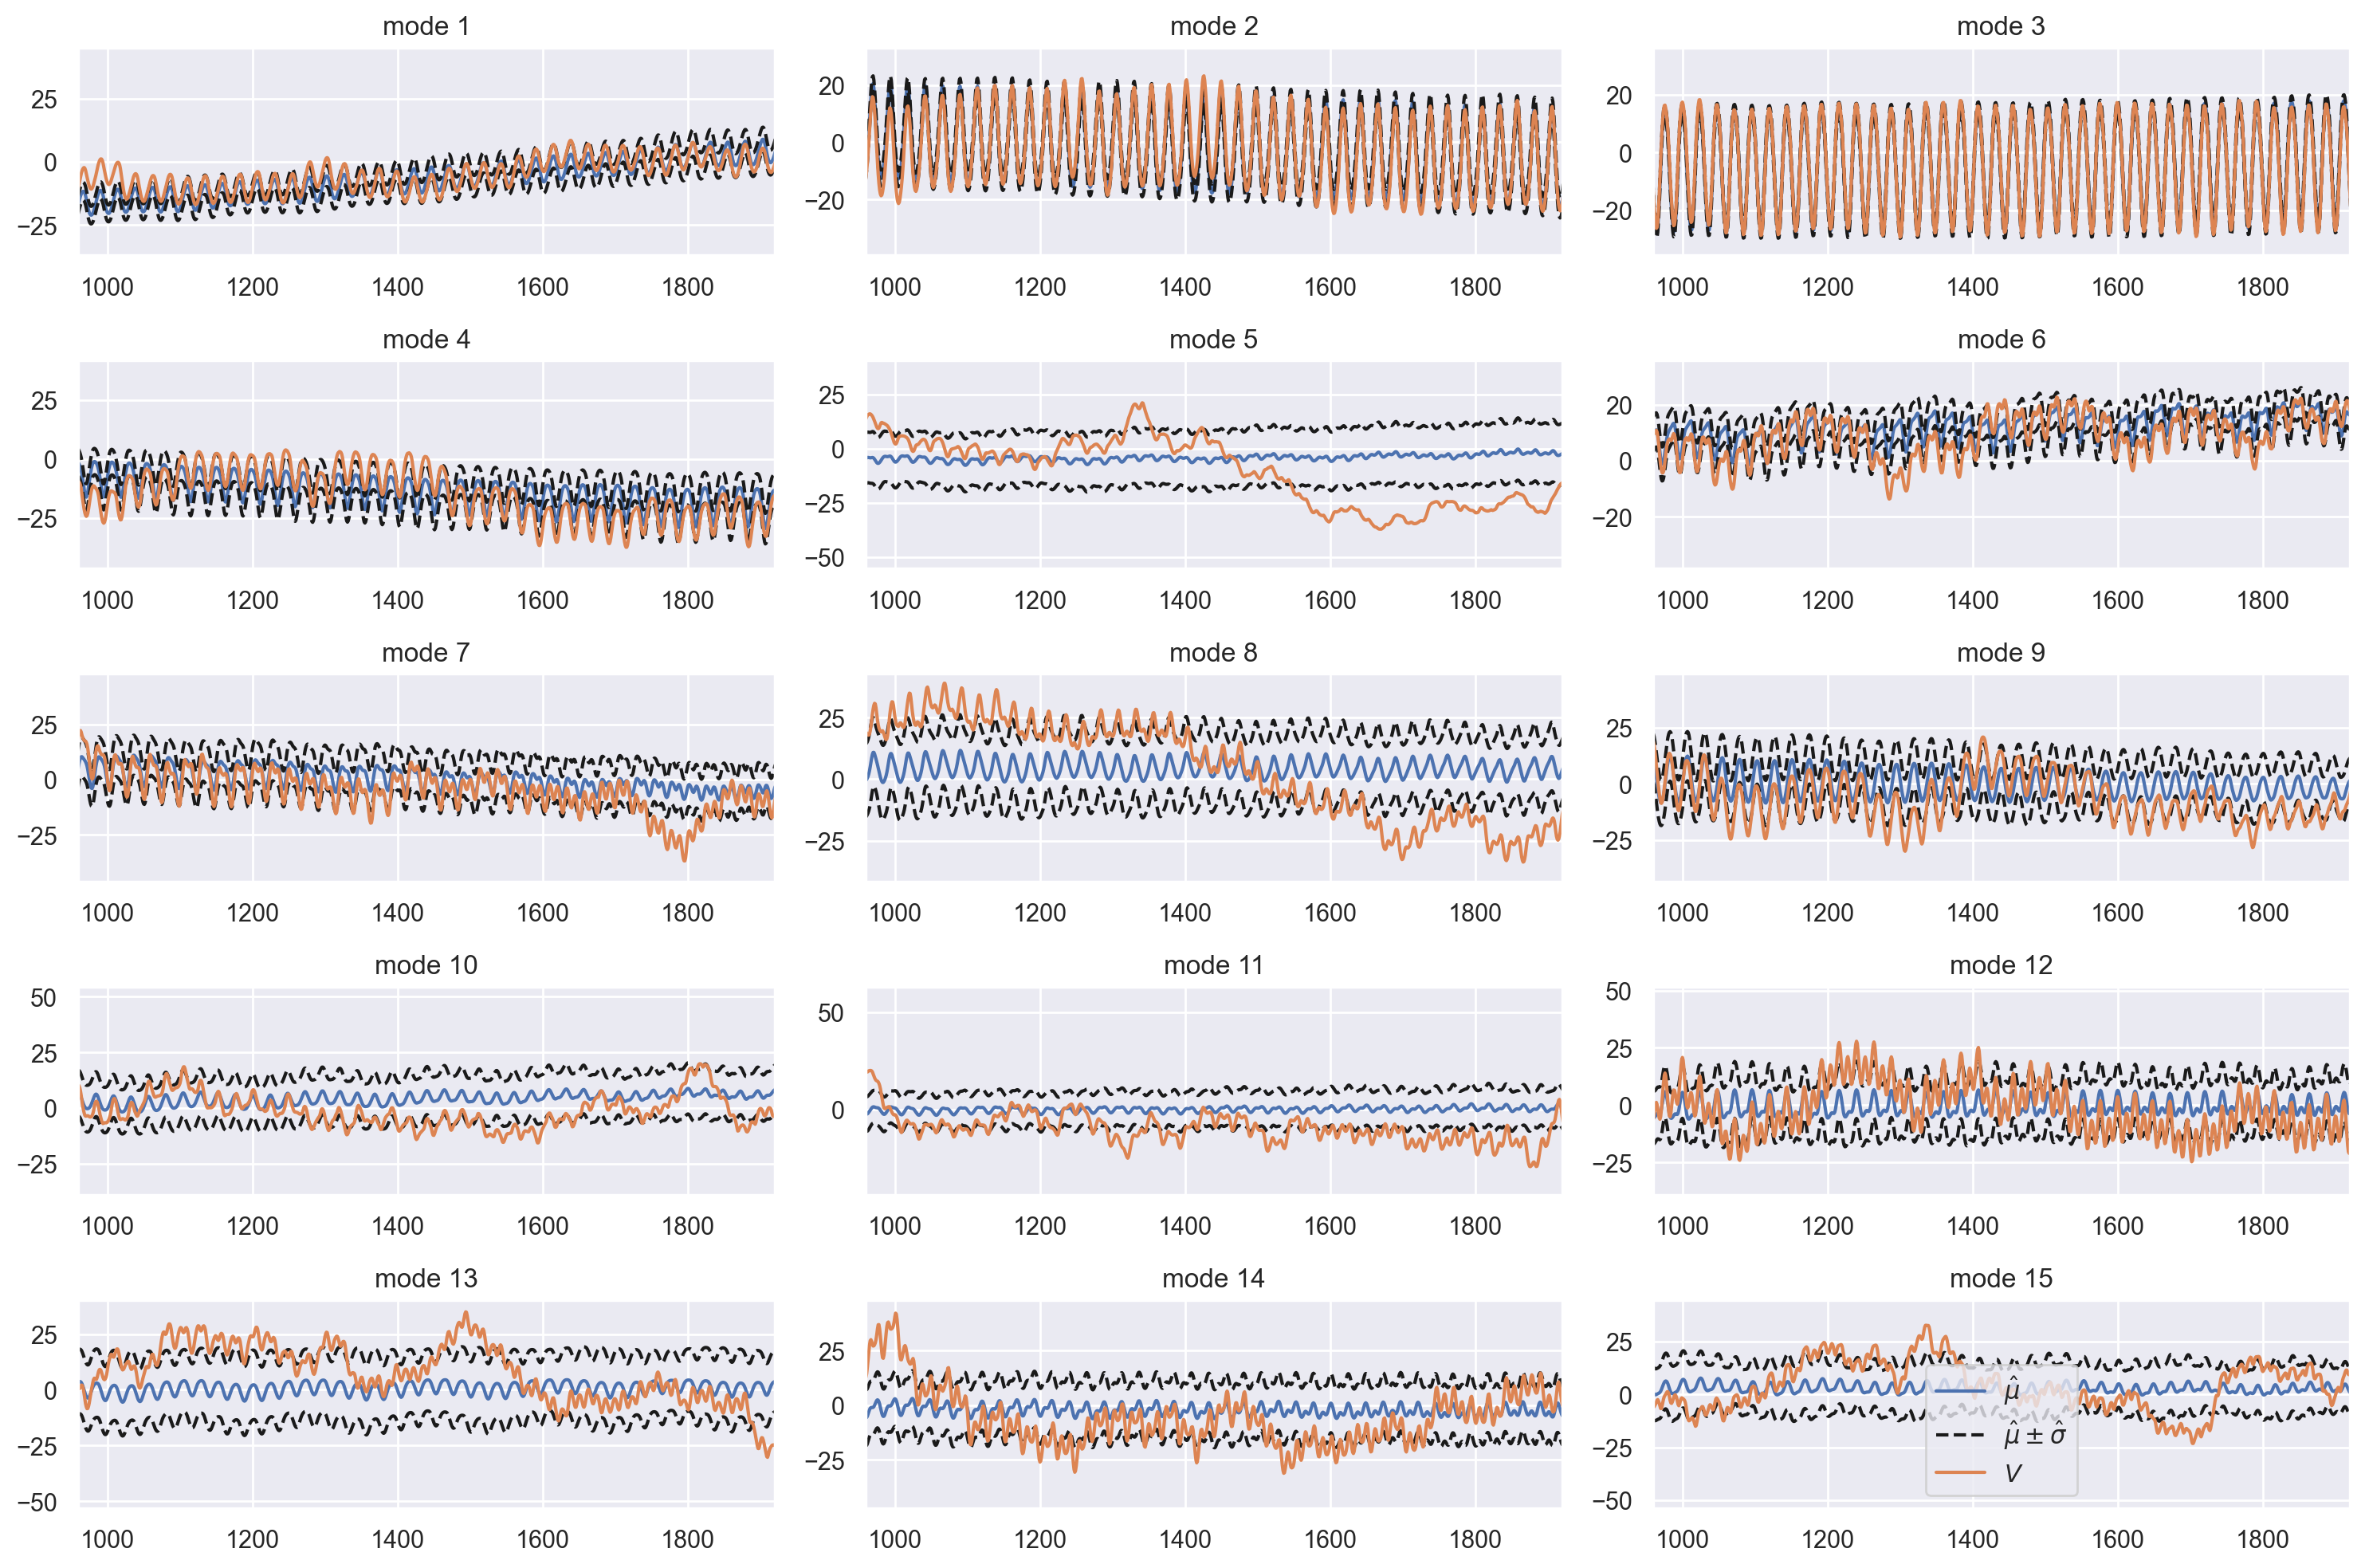

In [93]:
plt.subplots(5, 3, figsize=(15, 10), dpi=200)
start = 0
for i in range(start, start + 15):
    plt.subplot(5, 3, i + 1 - start)
    plt.title(f"mode {i + 1}")
    plt.plot(mean_hat[:, i], label="$\hat \mu$")
    plt.plot(mean_hat[:, i] + std_hat[:, i], "--k", label="$\hat \mu \pm \hat \sigma$")
    plt.plot(mean_hat[:, i] - std_hat[:, i], "--k")
    plt.plot(V[:H, i], label="$V$")
    plt.xlim([960, 1920])
plt.tight_layout()
plt.legend()
plt.show()